In [8]:
import matplotlib.pyplot as plt
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate, VerticalFlip, Crop, PixelDropout, CropAndPad, RandomBrightnessContrast
)
import config
import paths
import randomness
from cnn_builder import *
from config import *
from dataset_functions import *
from functools import partial
from hypercube_set import HypercubeSet
from hypercube_loader import *
import numpy as np
import papers

import os

os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'
os.chdir(os.getcwd().split("jupyter")[0])

inf = 2e32

% load_ext autoreload
% autoreload 2
% pylab inline

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
2 Physical GPUs, 2 Logical GPUs


C:\Users\allopezr\Documents\GitHub\VineyardUAVClassification\venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning:

pylab import has clobbered these variables: ['copy', 'random', 'inf', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy



In [2]:
font_mapping = {'family': 'Palatino Linotype', 'weight': 'normal', 'size': 11}
plt.rc('font', **font_mapping)

In [3]:
hc_array_red, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf,
                                                 folder='media/Mateus_2022/red/')
hc_array_white, max_class_idx, _ = load_hypercubes(plot_hc=False, plot_mask=False, n_max_cubes=inf,
                                                   folder='media/Mateus_2022/white/', baseline_class_idx=max_class_idx)

hc_array = hc_array_red + hc_array_white
hc_set = HypercubeSet(hc_array)
hc_set.print_num_samples()

Reading media/Mateus_2022/red\raw_112_rf.hdr ...
Hypercube shape: (1872, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_1984_rf.hdr ...
Hypercube shape: (1920, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_3904_rf.hdr ...
Hypercube shape: (1840, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (128, 128, 255): 8}
Reading media/Mateus_2022/red\raw_5744_rf.hdr ...
Hypercube shape: (1840, 640, 270)
{(0, 0, 0): 0, (255, 128, 255): 1, (192, 128, 255): 2, (255, 128, 0): 3, (255, 255, 128): 4, (128, 255, 0): 5, (128, 255, 128): 6, (128, 255, 255): 7, (

In [4]:
hc_set.identify_ground_samples()

In [5]:
network_type = 'allopezr_2d'
read_json_config(paths.config_file, network_type=network_type)
network_name = get_name(network_type)

In [6]:
hc_set.split_hypercubes(test_percentage=config.test_split)
hc_set.standardize(num_features=config.num_target_features, selection_method=LayerSelectionMethod.FACTOR_ANALYSIS)

Train size: 123941, Test size: 21873
Train size: 131207, Test size: 23155
Train size: 101716, Test size: 17950
Train size: 94119, Test size: 16610
Train size: 9856, Test size: 1740
Train size: 58781, Test size: 10374
Train size: 143288, Test size: 25287
Train size: 68962, Test size: 12170
Train size: 192792, Test size: 34023
Train size: 76042, Test size: 13420
Train size: 193339, Test size: 34119
Train size: 54054, Test size: 9539
Train size: 94259, Test size: 16635
|████████████████████████████████████████| 52/52 [100%] in 1:06.0 (0.78/s)                                               ▄▂▂ 25/52 [48%] in 21s (~22s, 1.2/s) 


(FactorAnalysis(n_components=40, random_state=42), StandardScaler())

In [7]:
num_classes = hc_set.get_num_classes() - 1
img_shape = (config.patch_size, config.patch_size, config.num_target_features)
num_iterations = int(config.epochs / config.num_training_splits / config.num_transformation_iterations)
percentage_step = 1.0 / config.num_training_splits

In [11]:
transforms = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    Rotate(limit=(-360, -360), p=0.1),
    Rotate(limit=(-270, -270), p=0.1),
    Rotate(limit=(-180, -180), p=0.1),
    Rotate(limit=(-90, -90), p=0.1),
    Rotate(limit=(90, 90), p=0.1),
    Rotate(limit=(180, 180), p=0.1),
    Rotate(limit=(270, 270), p=0.1)
])

network_file = paths.result_folder + 'network/' + network_name + '_han_chuan_0.h5'
model = keras.models.load_model(network_file,
                                custom_objects={'SpatialAttention': papers.aspn.SpatialAttention,
                                                'SecondOrderPooling': papers.aspn.SecondOrderPooling})
x = Dense(num_classes, activation=config.last_activation)(model.layers[-2].output)
model = Model(inputs=model.input, outputs=x)
network_name += '_transfer_learning'
compile_network(model, network_type, network_name, num_classes, show_summary=True, render_image=True)

# model.trainable = True
# for (idx, layer) in enumerate(model.layers):
#     if idx not in trainable_layers[experiment_id]:
#         model.layers[idx].trainable = False

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 23, 23, 40)  0           []                               
                                ]                                                                 
                                                                                                  
 reshape (Reshape)              (None, 529, 40)      0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 529, 40)      0           ['reshape[0][0]']                
                                                                                                  
 spatial_attention (SpatialAtte  (None, 529, 40)     1058        ['lambda[0][0]']             

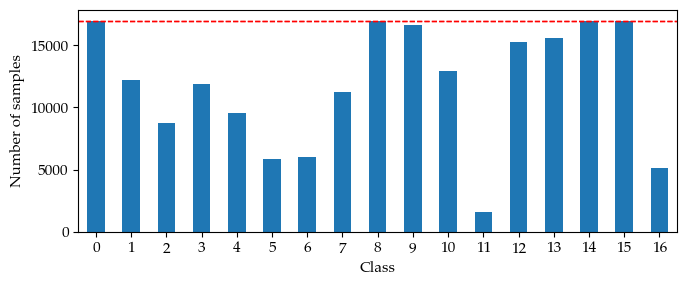

Training for 40 epochs with batch size of 1024...
Epoch 1/40
176/176 [==============================] - ETA: 0s - loss: 1.6129 - sparse_categorical_accuracy: 0.4593
Epoch 1: val_loss improved from inf to 1.05502, saving model to results/uav/network\allopezr_2d_23x22_16_transfer_learning_0.h5
176/176 [==============================] - 26s 99ms/step - loss: 1.6129 - sparse_categorical_accuracy: 0.4593 - val_loss: 1.0550 - val_sparse_categorical_accuracy: 0.6316
Epoch 2/40
176/176 [==============================] - ETA: 0s - loss: 0.9200 - sparse_categorical_accuracy: 0.6712
Epoch 2: val_loss improved from 1.05502 to 0.77390, saving model to results/uav/network\allopezr_2d_23x22_16_transfer_learning_0.h5
176/176 [==============================] - 15s 88ms/step - loss: 0.9200 - sparse_categorical_accuracy: 0.6712 - val_loss: 0.7739 - val_sparse_categorical_accuracy: 0.7232
Epoch 3/40
176/176 [==============================] - ETA: 0s - loss: 0.6978 - sparse_categorical_accuracy: 0.7455
Epo

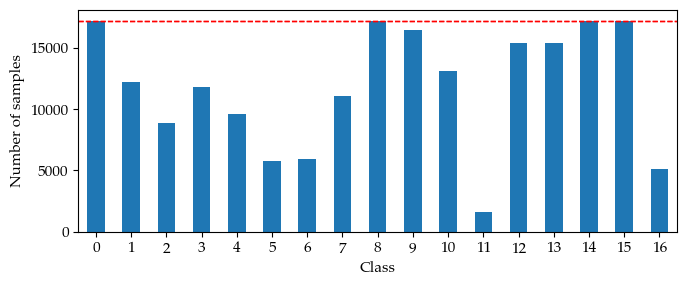

Training for 40 epochs with batch size of 1024...
Epoch 1/40
177/177 [==============================] - ETA: 0s - loss: 0.0694 - sparse_categorical_accuracy: 0.9773
Epoch 1: val_loss improved from 0.05958 to 0.05942, saving model to results/uav/network\allopezr_2d_23x22_16_transfer_learning_0.h5
177/177 [==============================] - 18s 98ms/step - loss: 0.0694 - sparse_categorical_accuracy: 0.9773 - val_loss: 0.0594 - val_sparse_categorical_accuracy: 0.9800
Epoch 2/40
177/177 [==============================] - ETA: 0s - loss: 0.0569 - sparse_categorical_accuracy: 0.9802
Epoch 2: val_loss did not improve from 0.05942
177/177 [==============================] - 15s 87ms/step - loss: 0.0569 - sparse_categorical_accuracy: 0.9802 - val_loss: 0.0605 - val_sparse_categorical_accuracy: 0.9804
Epoch 3/40
177/177 [==============================] - ETA: 0s - loss: 0.0518 - sparse_categorical_accuracy: 0.9817
Epoch 3: val_loss improved from 0.05942 to 0.05755, saving model to results/uav/netw

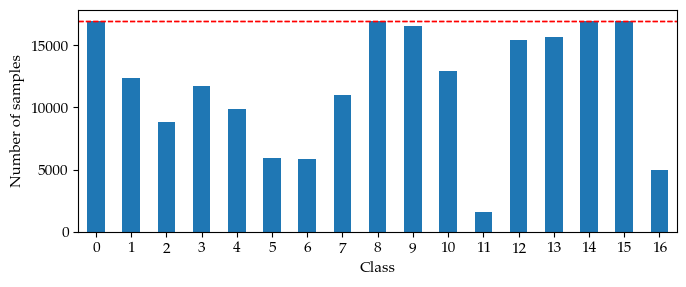

Training for 40 epochs with batch size of 1024...
Epoch 1/40
176/176 [==============================] - ETA: 0s - loss: 0.0478 - sparse_categorical_accuracy: 0.9857
Epoch 1: val_loss did not improve from 0.03133
176/176 [==============================] - 17s 97ms/step - loss: 0.0478 - sparse_categorical_accuracy: 0.9857 - val_loss: 0.0449 - val_sparse_categorical_accuracy: 0.9869
Epoch 2/40
176/176 [==============================] - ETA: 0s - loss: 0.0399 - sparse_categorical_accuracy: 0.9871
Epoch 2: val_loss improved from 0.03133 to 0.03120, saving model to results/uav/network\allopezr_2d_23x22_16_transfer_learning_0.h5
176/176 [==============================] - 15s 87ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.0312 - val_sparse_categorical_accuracy: 0.9904
Epoch 3/40
176/176 [==============================] - ETA: 0s - loss: 0.0352 - sparse_categorical_accuracy: 0.9885
Epoch 3: val_loss improved from 0.03120 to 0.02978, saving model to results/uav/netw

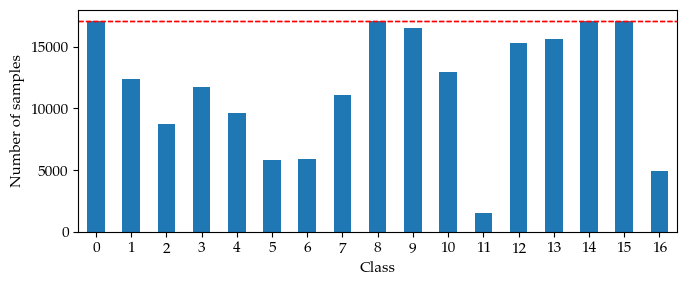

Training for 40 epochs with batch size of 1024...
Epoch 1/40
177/177 [==============================] - ETA: 0s - loss: 0.0369 - sparse_categorical_accuracy: 0.9893
Epoch 1: val_loss did not improve from 0.02449
177/177 [==============================] - 18s 102ms/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0452 - val_sparse_categorical_accuracy: 0.9869
Epoch 2/40
176/177 [============================>.] - ETA: 0s - loss: 0.0309 - sparse_categorical_accuracy: 0.9905
Epoch 2: val_loss did not improve from 0.02449
177/177 [==============================] - 16s 91ms/step - loss: 0.0309 - sparse_categorical_accuracy: 0.9905 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9891
Epoch 3/40
176/177 [============================>.] - ETA: 0s - loss: 0.0279 - sparse_categorical_accuracy: 0.9910
Epoch 3: val_loss did not improve from 0.02449
177/177 [==============================] - 15s 87ms/step - loss: 0.0279 - sparse_categorical_accuracy: 0.9910 - val_loss:

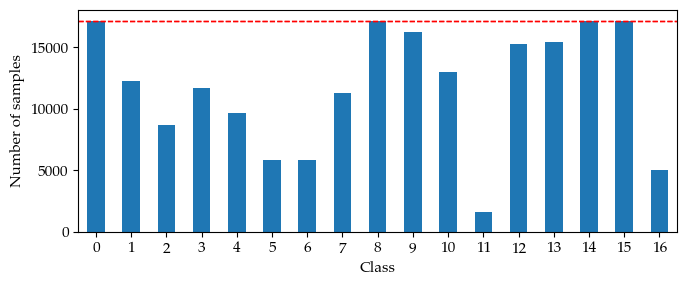

Training for 40 epochs with batch size of 1024...
Epoch 1/40
176/176 [==============================] - ETA: 0s - loss: 0.0304 - sparse_categorical_accuracy: 0.9914
Epoch 1: val_loss did not improve from 0.01961
176/176 [==============================] - 18s 100ms/step - loss: 0.0304 - sparse_categorical_accuracy: 0.9914 - val_loss: 0.0288 - val_sparse_categorical_accuracy: 0.9922
Epoch 2/40
176/176 [==============================] - ETA: 0s - loss: 0.0258 - sparse_categorical_accuracy: 0.9920
Epoch 2: val_loss did not improve from 0.01961
176/176 [==============================] - 16s 89ms/step - loss: 0.0258 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.0215 - val_sparse_categorical_accuracy: 0.9945
Epoch 3/40
176/176 [==============================] - ETA: 0s - loss: 0.0210 - sparse_categorical_accuracy: 0.9933
Epoch 3: val_loss improved from 0.01961 to 0.01714, saving model to results/uav/network\allopezr_2d_23x22_16_transfer_learning_0.h5
176/176 [===========================

In [12]:
import gc

history = training_history.TrainingHistory(accuracy_name='sparse_categorical_accuracy')
callbacks, time_callback = get_callback_list(model_name=network_name)

### Training
for batch in range(config.num_training_splits):
    X_train, y_train = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping, train=True,
                                    start_percentage=percentage_step * batch,
                                    end_percentage=percentage_step * (batch + 1))
    X_train, y_train = randomness.stratified_sampling(X_train, y_train, use_float=True, num_reduced_classes=3)
    render_mask_histogram(y_train)

    for it in range(config.num_transformation_iterations):
        X_train_transformed = X_train.copy()

        for i in range(len(X_train_transformed)):
            random_seed = np.random.randint(0, X_train_transformed.shape[0] * 10)
            for layer in range(X_train_transformed.shape[-1]):
                randomness.set_seed(random_seed)
                X_train_transformed[i, :, :, layer] = transforms(image=X_train_transformed[i, :, :, layer])["image"]

        X_train_it, X_validation_it, y_train_it, y_validation_it = split_train_test(X_train_transformed, y_train,
                                                                                    test_size=config.validation_split * (
                                                                                            1.0 - config.test_split),
                                                                                    random_seed=randomness.random_seed)

        del X_train_transformed
        gc.collect()

        history.append_history(
            run_model(model, X_train_it, y_train_it, X_validation_it, y_validation_it, callbacks=callbacks,
                      num_epochs=num_iterations).history, time_callback)

        del X_train_it, X_validation_it, y_train_it, y_validation_it
        gc.collect()

    del X_train, y_train
    gc.collect()

1411/1411 [==============================] - 12s 9ms/step - loss: 0.0361 - sparse_categorical_accuracy: 0.9904
Test Loss: 0.03614341840147972, Test Accuracy: 0.9903611540794373
1410/1410 [==============================] - 13s 9ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9903
Test Loss: 0.040570102632045746, Test Accuracy: 0.9902658462524414
1410/1410 [==============================] - 13s 9ms/step - loss: 0.0393 - sparse_categorical_accuracy: 0.9906
Test Loss: 0.039284247905015945, Test Accuracy: 0.9905574917793274
1409/1409 [==============================] - 12s 9ms/step - loss: 0.0422 - sparse_categorical_accuracy: 0.9897
Test Loss: 0.04223888739943504, Test Accuracy: 0.9896829724311829
1409/1409 [==============================] - 12s 9ms/step - loss: 0.0381 - sparse_categorical_accuracy: 0.9910
Test Loss: 0.03805720433592796, Test Accuracy: 0.9910387396812439


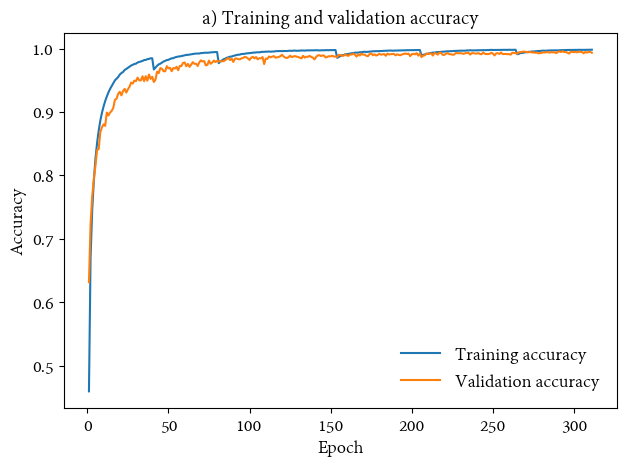

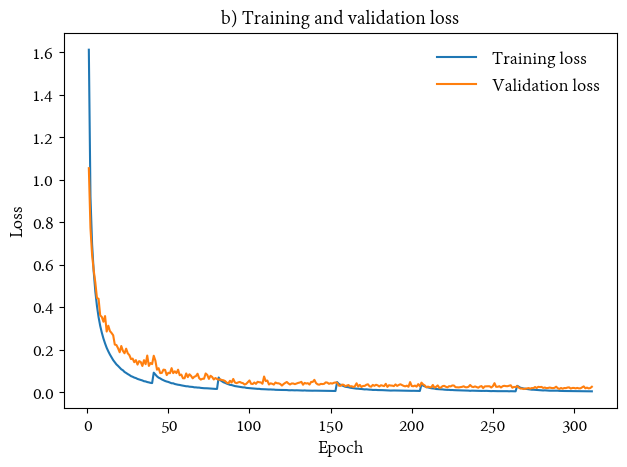

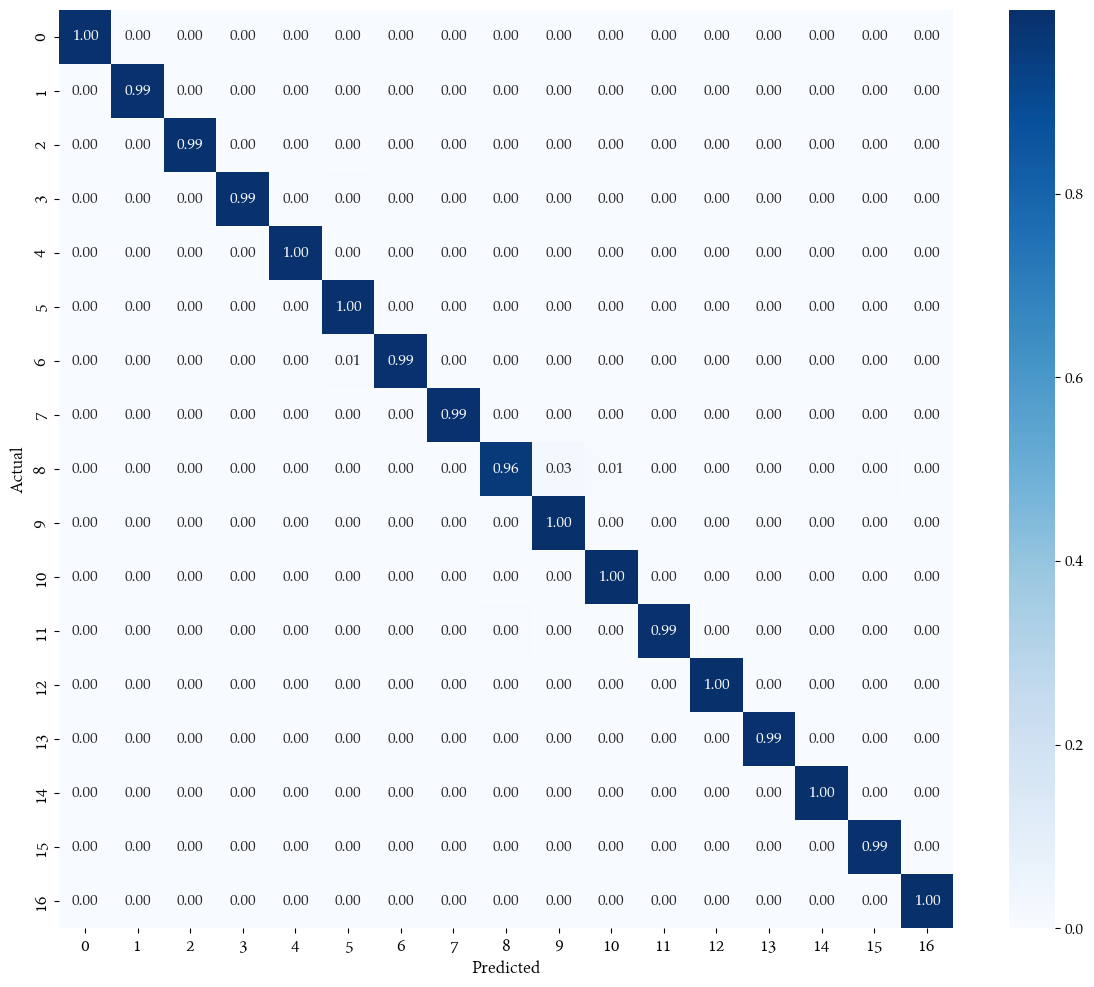

In [13]:
#### Split test into batches
y_test_global = []
test_prediction_global = []
test_prediction_prob_global = []

for batch in range(config.num_test_splits):
    X_test, y_test = hc_set.split(patch_size=config.patch_size, patch_overlap=config.patch_overlapping,
                                  train=False, start_percentage=percentage_step * batch,
                                  end_percentage=percentage_step * (batch + 1))
    test_prediction_prob = model.predict(X_test)
    test_prediction = np.argmax(test_prediction_prob, axis=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print("Test Loss: " + str(test_loss) + ", Test Accuracy: " + str(test_accuracy))

    # y test to int
    y_test_global.extend(np.asarray(y_test, dtype="int64").tolist())
    test_prediction_global.extend(test_prediction.tolist())
    test_prediction_prob_global.extend(test_prediction_prob.tolist())

    del X_test, y_test, test_prediction, test_prediction_prob
    gc.collect()

y_test_global = np.asarray(y_test_global)
test_prediction_global = np.asarray(test_prediction_global)
test_prediction_prob_global = np.asarray(test_prediction_prob_global)

# Graphic results
render_model_history(history, model_name=network_name)
render_confusion_matrix(y_test_global, test_prediction_global, model_name=network_name)